# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/ECE_661/661_Final_Project')

In [ ]:
# import necessary dependencies
import argparse
import os
import time
import tools
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

In [ ]:
# define the ResBlock to be used in ResNet;
class ResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, k_size=3, stride_bool=False):
        super(ResBlock, self).__init__()
        if(stride_bool == True):
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, stride=2, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=2)
        else:
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1)

        if input_dim != output_dim:
          input_dim = output_dim
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.conv2 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        y = x
      # Note shortcut will just be x if of same shape as out
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out)) 
        if (x.shape == out.shape):
          out = out + y
          out = F.relu(out)
          return out
        else:
          y = self.resconv(y)
          out = out.add(y)
          out = F.relu(out)
          return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    # 16 filter res blockss
    self.res1 = ResBlock(16, 16)
    self.res2 = ResBlock(16, 16)
    self.res3 = ResBlock(16, 16)
    # Now 32 filter res blocks
    self.res4 = ResBlock(16, 32, stride_bool=True)
    self.res5 = ResBlock(32, 32)
    self.res6 = ResBlock(32, 32)
    # Now 64 filter res blocks 
    self.res7 = ResBlock(32, 64, stride_bool=True)
    self.res8 = ResBlock(64, 64)
    self.res9 = ResBlock(64, 64)

    self.fc = nn.Linear(64, 10)
    self.fc2 = nn.Linear(64,4)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))

    # ReLU contained within forward method of res blocks
    
    out = self.res1(out)
    out = self.res2(out)
    out = self.res3(out)

    out = self.res4(out)
    out = self.res5(out)
    out = self.res6(out)

    out = self.res7(out)
    out = self.res8(out)
    out = self.res9(out)

    out = F.adaptive_avg_pool2d(out, 1)
    out = out.view(out.size(0), -1)
    outt = self.fc(out)
    outr = self.fc2(out)
    # out = F.softmax(out)
    return outt, outr

## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint: 
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [ ]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function


### all of the transform methods are commented out because we are running it with no other regualization for the hyper param sweep to hopefully spread aprt more (make more sensitive)###
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])
                                      # transforms.RandomCrop(size=(32,32), padding=4),
                                      # transforms.RandomHorizontalFlip(), 
                                      # transforms.RandomRotation(degrees=15)]) 
                                      # transforms.GaussianBlur(kernel_size=5, sigma = 0.5)])

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [ ]:
# do NOT change these
#import tools
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=256,  # your code
    shuffle=True,     # your code
    num_workers=2
)
val_loader = DataLoader(
    val_set, 
    batch_size=256,  # your code
    shuffle=False,     # your code
    num_workers=2
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [ ]:
# specify the device for computation
#############################################
# your code here
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
  
    
#############################################

Run on GPU...


In [ ]:
!nvidia-smi

Thu Dec 15 02:24:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [ ]:
import torch.nn as nn
import torch.optim as optim

net = ResNet().to(device)
# state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_base.pth")
# net.load_state_dict(state_dict["state_dict"])
# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-5

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps: 

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


## Only data augmentation


In [ ]:
# Code borrowed from Facebook research paper: https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py
def mixup_data(x, y, alpha=1.0, use_cuda=True, lam = .5):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = lam
    

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

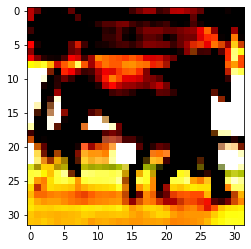

In [ ]:
import matplotlib.pyplot as plt
i = 0
xs = []
for x,y in train_set:
  xs.append(x)
  i += 1
  if i > 20:
    break
newx = 0.5 * xs[0] + 0.5 * xs[2]
x2 = np.transpose(xs[2], (1, 2, 0))
plt.imshow(x2)
# newx = np.transpose(newx, (1, 2, 0))
# plt.imshow(newx)

In [ ]:
# Just data augmentation

# some hyperparameters
# total number of training epochs
EPOCHS = 50
 
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

# Calculate initial loss 
initial_loss = 0
for batch_idx, (inputs, targets) in enumerate(train_loader):
  inputs = inputs.to(device)
  targets = targets.to(device)
  # compute the output and loss
  outputs = net(inputs)[0]
  initial_loss = criterion(outputs, targets)
  # initial_loss += loss
print("Initial loss: %.4f" %(initial_loss))

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
#     # handle the learning rate scheduler.
  #  if i % DECAY_EPOCHS == 0 and i != 0:
#         current_learning_rate = current_learning_rate * DECAY
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = current_learning_rate
#         print("Current learning rate has decayed to %f" %current_learning_rate)
    if 140 > i > 100  :
      current_learning_rate = 0.1
      for param_group in optimizer.param_groups:
          param_group['lr'] = current_learning_rate
      print("Current learning rate has decayed to %f" %current_learning_rate)
    if 170 > i > 140  :
      current_learning_rate = 0.001
      momentum = 0.6
      for param_group in optimizer.param_groups:
          param_group['lr'] = current_learning_rate
          param_group['momentum'] = momentum
      print("Current learning rate has decayed to %f" %current_learning_rate)
    if i > 170  :
      current_learning_rate = 0.0005
      momentum = 0.3
      for param_group in optimizer.param_groups:
          param_group['lr'] = current_learning_rate
          param_group['momentum'] = momentum
      print("Current learning rate has decayed to %f" %current_learning_rate)
    
    
    #######################
    # your code here
    # switch to train mode
    net.train()
    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        # Alpha is a hyperparam that will influence our lambda valie
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                       alpha=0.5, use_cuda=True, lam=0.5)
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = net(inputs)[0]
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss
        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        total_examples += targets.shape[0]
        correct_examples += correct.item()
        ####################################
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            outputs = net(inputs)[0]
            val_loss += criterion(outputs, targets)
                
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            total_examples += targets.shape[0]
            correct_examples += correct.item()
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet_mixup_noreg_50.pth'))
        # model.load_state_dict(state_dict["state_dict"])
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

Initial loss: 2.3287
==> Training starts!
Epoch 0:


KeyboardInterrupt: ignored

In [ ]:
print('now here we are doing fine tuning to show the difference in performance with the lamda hyper parameter for our mixup regualizer')

In [ ]:
# Just data augmentation
import torch.nn as nn
import torch.optim as optim
# some hyperparameters
# total number of training epochs
for lam in [.15, .3, .5,.7,.85]:
  net = ResNet().to(device)
  # state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_base_noreg_50.pth")
  # net.load_state_dict(state_dict["state_dict"])
  INITIAL_LR = 0.1

  # momentum for optimizer
  MOMENTUM = 0.9

  # L2 regularization strength
  REG = 1e-5

  #############################################
  # your code here
  # create loss function
  criterion = nn.CrossEntropyLoss().to(device)

  # Add optimizer
  optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay = REG) #momentum value from AlexNet
#############################################
  EPOCHS = 75
  
  # the folder where the trained model is saved
  CHECKPOINT_FOLDER = "./saved_model"

  # start the training/validation process
  # the process should take about 5 minutes on a GTX 1070-Ti
  # if the code is written efficiently.
  best_val_acc = 0
  current_learning_rate = INITIAL_LR

  # Calculate initial loss 
  initial_loss = 0
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)
    # compute the output and loss
    outputs = net(inputs)[0]
    initial_loss = criterion(outputs, targets)
    # initial_loss += loss
  print("Initial loss: %.4f" %(initial_loss))

  print("==> Training starts!")
  print("="*50)
  for i in range(0, EPOCHS):
  #     # handle the learning rate scheduler.
    #  if i % DECAY_EPOCHS == 0 and i != 0:
  #         current_learning_rate = current_learning_rate * DECAY
  #         for param_group in optimizer.param_groups:
  #             param_group['lr'] = current_learning_rate
  #         print("Current learning rate has decayed to %f" %current_learning_rate)
      if 140 > i > 100  :
        current_learning_rate = 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
      if 170 > i > 140  :
        current_learning_rate = 0.001
        momentum = 0.6
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
            param_group['momentum'] = momentum
        print("Current learning rate has decayed to %f" %current_learning_rate)
      if i > 170  :
        current_learning_rate = 0.0005
        momentum = 0.3
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
            param_group['momentum'] = momentum
        print("Current learning rate has decayed to %f" %current_learning_rate)
      
      
      #######################
      # your code here
      # switch to train mode
      net.train()
      #######################

      print("Epoch %d:" %i)
      # this help you compute the training accuracy
      total_examples = 0
      correct_examples = 0

      train_loss = 0 # track training loss if you want
      
      # Train the model for 1 epoch.
      for batch_idx, (inputs, targets) in enumerate(train_loader):
          ####################################
          # your code here
          # copy inputs to device
          inputs = inputs.to(device)
          targets = targets.to(device)
          # compute the output and loss
          # Alpha is a hyperparam that will influence our lambda valie
          # lam = 0
          inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                        alpha=-1, use_cuda=True, lam = lam)
          inputs, targets_a, targets_b = map(Variable, (inputs,
                                                        targets_a, targets_b))
          outputs = net(inputs)[0]
          loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
          train_loss += loss
          # zero the gradient
          optimizer.zero_grad()
          
          # backpropagation
          loss.backward()
          
          # apply gradient and update the weights
          optimizer.step()
          
          # count the number of correctly predicted samples in the current batch
          _, predicted = torch.max(outputs, 1)
          correct = predicted.eq(targets).sum()

          total_examples += targets.shape[0]
          correct_examples += correct.item()
          ####################################
                  
      avg_loss = train_loss / len(train_loader)
      avg_acc = correct_examples / total_examples
      print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

      # Validate on the validation dataset
      #######################
      # your code here
      # switch to eval mode
      net.eval()
      
      #######################

      # this help you compute the validation accuracy
      total_examples = 0
      correct_examples = 0
      
      val_loss = 0 # again, track the validation loss if you want

      # disable gradient during validation, which can save GPU memory
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(val_loader):
              ####################################
              # your code here
              # copy inputs to device
              inputs = inputs.to(device)
              targets = targets.to(device)
              # compute the output and loss
              outputs = net(inputs)[0]
              val_loss += criterion(outputs, targets)
                  
              # count the number of correctly predicted samples in the current batch
              _, predicted = torch.max(outputs, 1)
              correct = predicted.eq(targets).sum()

              total_examples += targets.shape[0]
              correct_examples += correct.item()
              ####################################
      name = 'resnet_mixup'+str(lam)+'.pth'
      avg_loss = val_loss / len(val_loader)
      avg_acc = correct_examples / total_examples
      print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
      
      # save the model checkpoint
      if avg_acc > best_val_acc:
          best_val_acc = avg_acc
          if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
          print("Saving ...")
          state = {'state_dict': net.state_dict(),
                  'epoch': i,
                  'lr': current_learning_rate}
          torch.save(state, os.path.join(CHECKPOINT_FOLDER, name))
          # model.load_state_dict(state_dict["state_dict"])
      print('')

  print("="*50)
  print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

Initial loss: 2.3384
==> Training starts!
Epoch 0:
Training loss: 1.8358, Training accuracy: 0.1117
Validation loss: 1.9195, Validation accuracy: 0.3600
Saving ...

Epoch 1:
Training loss: 1.4848, Training accuracy: 0.1136
Validation loss: 1.3287, Validation accuracy: 0.5406
Saving ...

Epoch 2:
Training loss: 1.3209, Training accuracy: 0.1102
Validation loss: 0.9481, Validation accuracy: 0.6888
Saving ...

Epoch 3:
Training loss: 1.2255, Training accuracy: 0.1093
Validation loss: 0.9017, Validation accuracy: 0.7092
Saving ...

Epoch 4:
Training loss: 1.1607, Training accuracy: 0.1077
Validation loss: 0.8550, Validation accuracy: 0.7268
Saving ...

Epoch 5:
Training loss: 1.1097, Training accuracy: 0.1096
Validation loss: 0.8344, Validation accuracy: 0.7418
Saving ...

Epoch 6:
Training loss: 1.0719, Training accuracy: 0.1068
Validation loss: 0.8637, Validation accuracy: 0.7206

Epoch 7:
Training loss: 1.0426, Training accuracy: 0.1049
Validation loss: 0.8042, Validation accuracy: 0.74